MACHINE LEARNING PROJECT - V6



  Make       Model  Year             Engine Fuel Type  Engine HP  \
0  BMW  1 Series M  2011  premium unleaded (required)      335.0   
1  BMW    1 Series  2011  premium unleaded (required)      300.0   
2  BMW    1 Series  2011  premium unleaded (required)      300.0   
3  BMW    1 Series  2011  premium unleaded (required)      230.0   
4  BMW    1 Series  2011  premium unleaded (required)      230.0   

   Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors  \
0               6.0            MANUAL  rear wheel drive              2.0   
1               6.0            MANUAL  rear wheel drive              2.0   
2               6.0            MANUAL  rear wheel drive              2.0   
3               6.0            MANUAL  rear wheel drive              2.0   
4               6.0            MANUAL  rear wheel drive              2.0   

                         Market Category Vehicle Size Vehicle Style  \
0  Factory Tuner,Luxury,High-Performance      Compact         C

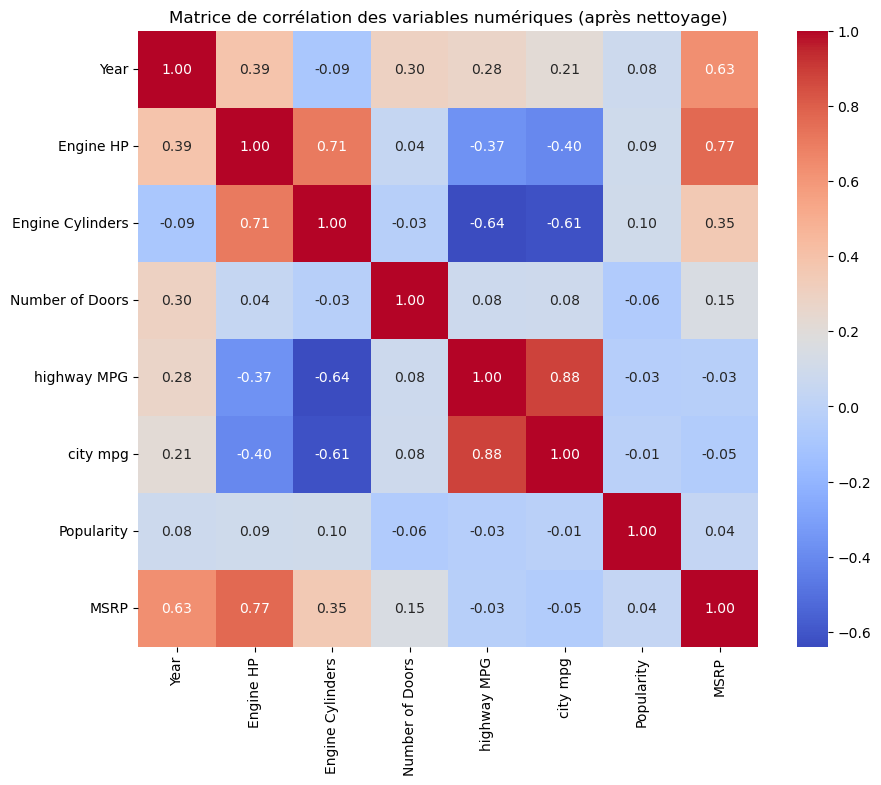

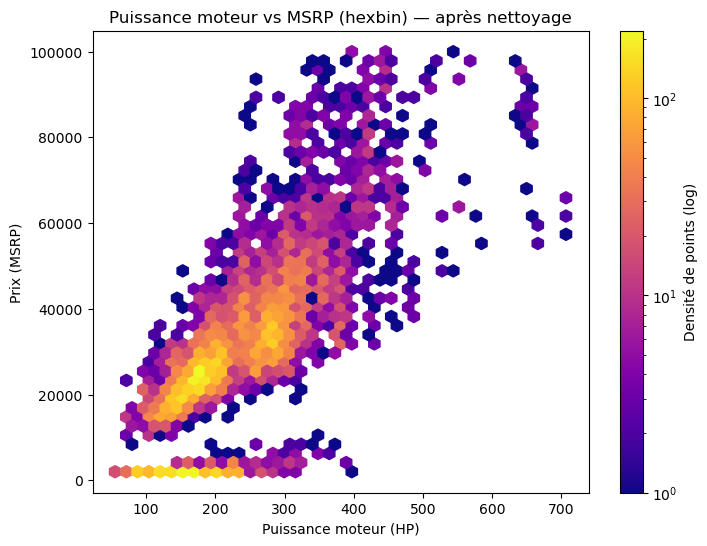

C:\Users\alexi\AppData\Local\Temp\ipykernel_29184\2317270707.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')


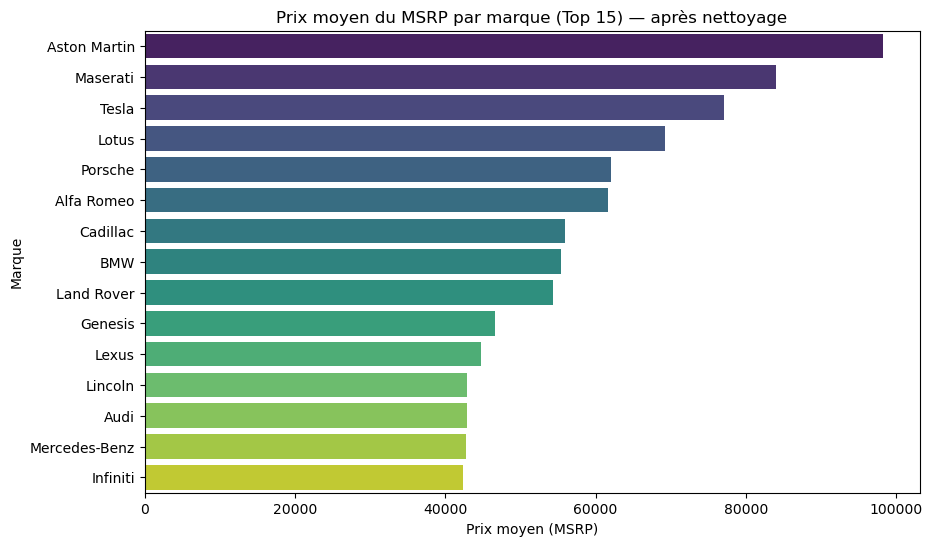

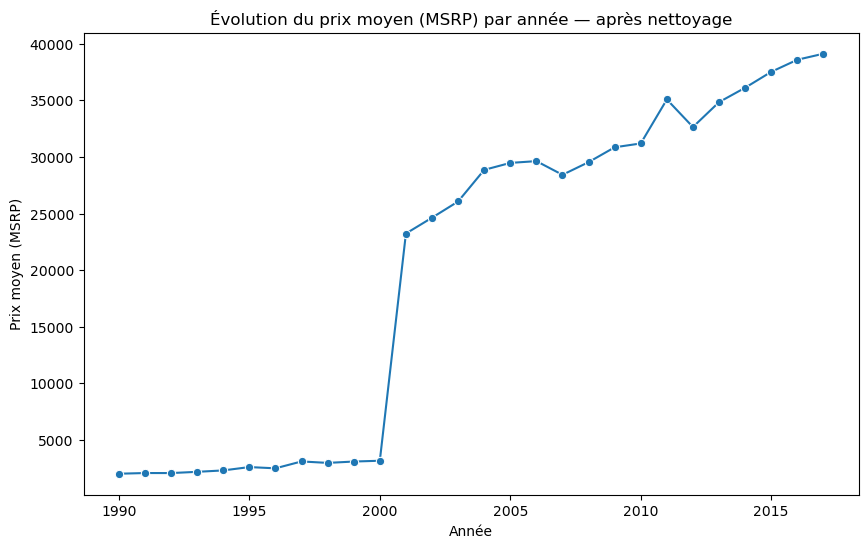

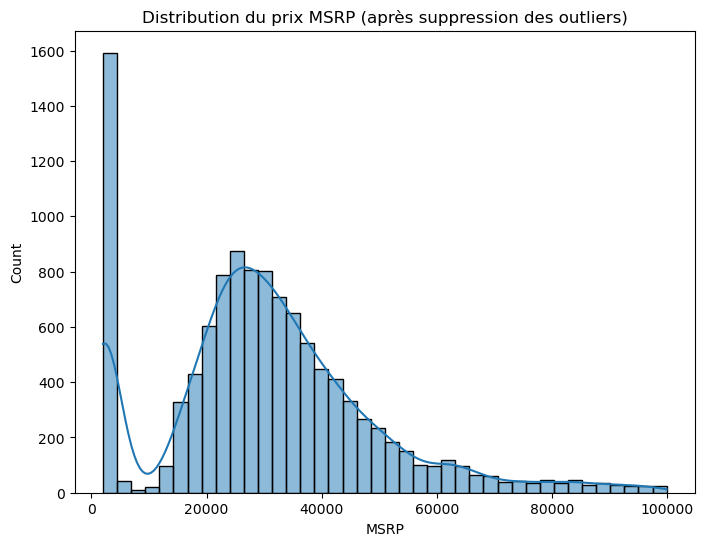

Nombre de marques pour les voitures < 100k : 40


In [62]:
# 1. Descriptive analysis of data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === A. Chargement du dataset brut ===
df = pd.read_csv('data.csv')

print(df.head())
print(df.info())
print(df.describe(include='all'))

# Valeurs manquantes
print(df.isnull().sum())

# Statistiques sur la variable cible MSRP
print("Statistiques sur la colonne MSRP :")
print(df['MSRP'].describe())

# Informations sur les colonnes catégorielles
categoricals = ['Make', 'Model', 'Engine Fuel Type', 'Transmission Type',
                'Driven_Wheels', 'Vehicle Size', 'Vehicle Style']

for col in categoricals:
    print(f"--- {col} ---")
    print("Valeurs uniques :", df[col].nunique())
    print(df[col].value_counts().head(10))
    print()


# === B. Création du df_clean (dataset nettoyé) ===

# Suppression des véhicules très haut de gamme (MSRP >= 100 000)
df_clean = df[df['MSRP'] < 100000]

# Nombre de véhicules conservés
print(f"Nombre de véhicules après filtrage (MSRP < 100 000) : {df_clean.shape[0]}")


# Suppression de la colonne inutilisable
df_clean = df_clean.drop(columns=['Market Category'])

# (IMPORTANT) La suppression des colonnes multicolinéaires viendra ensuite
# car `cols_to_remove` est défini dans une cellule ultérieure.


# === C. Visualisations après nettoyage ===

# Matrice de corrélation
plt.figure(figsize=(10,8))
corr = df_clean.select_dtypes(include=['number']).corr()

sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Matrice de corrélation des variables numériques (après nettoyage)")
plt.show()

# Hexbin Engine HP vs MSRP
plt.figure(figsize=(8,6))
plt.hexbin(df_clean['Engine HP'], df_clean['MSRP'], gridsize=40,
           cmap='plasma', bins='log')
plt.colorbar(label='Densité de points (log)')
plt.title("Puissance moteur vs MSRP (hexbin) — après nettoyage")
plt.xlabel("Puissance moteur (HP)")
plt.ylabel("Prix (MSRP)")
plt.show()

# Prix moyen par marque
plt.figure(figsize=(10,6))
top_brands = df_clean.groupby('Make')['MSRP'].mean().sort_values(ascending=False).head(15)

sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')
plt.title("Prix moyen du MSRP par marque (Top 15) — après nettoyage")
plt.xlabel("Prix moyen (MSRP)")
plt.ylabel("Marque")
plt.show()

# Evolution par année
plt.figure(figsize=(10,6))
yearly_price = df_clean.groupby('Year')['MSRP'].mean().reset_index()

sns.lineplot(data=yearly_price, x='Year', y='MSRP', marker='o')
plt.title("Évolution du prix moyen (MSRP) par année — après nettoyage")
plt.xlabel("Année")
plt.ylabel("Prix moyen (MSRP)")
plt.show()

# Distribution du MSRP
plt.figure(figsize=(8,6))
sns.histplot(df_clean['MSRP'], kde=True, bins=40)
plt.title("Distribution du prix MSRP (après suppression des outliers)")
plt.xlabel("MSRP")
plt.show()
# Filtrage des voitures < 100k
df_under_100k = df[df["MSRP"] < 100000]

# Nombre de marques distinctes
nb_brands = df_under_100k["Make"].nunique()

print(f"Nombre de marques pour les voitures < 100k : {nb_brands}")


On remarque dans l’analyse initiale que la colonne Market Category présente 3 742 valeurs manquantes, ce qui la rend inexploitable pour la suite du projet. Nous choisissons donc de la supprimer.
La colonne Engine HP contient également des valeurs manquantes (69 au total), mais nous décidons de la conserver car la matrice de corrélation montre qu’elle est fortement corrélée au MSRP et constitue ainsi une variable explicative importante pour prédire le prix d’un véhicule.

Par ailleurs, la matrice de corrélation complète entre toutes les variables numériques n’est pas toujours facile à interpréter, notamment en raison de la présence de colonnes fortement redondantes entre elles (multicolinéarité). Une analyse plus pertinente consiste à examiner la corrélation entre le MSRP et chaque variable prise individuellement, ce qui permet d’identifier rapidement les attributs ayant le plus d’influence sur le prix.

Enfin, l’examen de la distribution du MSRP met en évidence la présence d’outliers extrêmes — principalement des supercars et modèles très haut de gamme. Ces observations, bien qu’intéressantes, sont très éloignées de la majorité des véhicules du dataset et introduisent une forte distorsion dans les analyses statistiques ainsi que dans l’entraînement du modèle. Pour éviter que ces valeurs atypiques ne dégradent les performances du modèle et n’absorbent une part disproportionnée de la variance, nous décidons de retirer le top 1 % des prix les plus élevés. Ce nettoyage permet d’obtenir un dataset plus homogène, des visualisations plus claires, ainsi qu’un modèle plus stable et représentatif de la majorité du marché automobile.

In [43]:
df_encoded = pd.get_dummies(df_clean, drop_first=True)

corr_matrix = df_encoded.corr()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.85)]

print("Colonnes corrélées dans df_encoded :")
print(high_corr)

# Colonnes existantes dans df_clean
cols_to_remove = [col for col in high_corr if col in df_clean.columns]

if 'MSRP' in cols_to_remove:
    cols_to_remove.remove('MSRP')

print("\nColonnes réellement supprimées :")
print(cols_to_remove)

df_clean = df_clean.drop(columns=cols_to_remove)

Colonnes corrélées dans df_encoded :
['city mpg', 'Model_4C', 'Model_G80', 'Model_Model S', 'Model_V8 Vantage', 'Transmission Type_DIRECT_DRIVE']

Colonnes réellement supprimées :
['city mpg']


Pour cette étape, nous cherchons à identifier les colonnes qui sont trop fortement corrélées entre elles et qui risquent d’apporter de la redondance au modèle. Pour cela, nous transformons temporairement df_clean en données numériques (pd.get_dummies) afin de pouvoir calculer une matrice de corrélation complète, incluant les variables catégorielles.

Cette analyse met en évidence plusieurs colonnes encodées très corrélées, notamment certains modèles spécifiques (ex : Model_C8, Model_Gallardo). Cela est normal, car ces modèles possèdent des caractéristiques techniques très homogènes. Cependant, ces colonnes n’existent que dans le tableau encodé et ne font pas partie du dataframe réel df_clean.

En filtrant uniquement les colonnes réellement présentes dans df_clean, on constate que seule la variable city mpg est effectivement redondante (fortement corrélée avec highway mpg). Nous choisissons donc de la supprimer pour éviter la multicolinéarité et alléger le modèle, sans perte d’information utile.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce

# Séparation des colonnes numériques / catégorielles
num_cols = df_clean.select_dtypes(include=['number']).columns.tolist()
num_cols.remove('MSRP')

cat_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

print("Num cols :", num_cols)
print("Cat cols :", cat_cols)

# Préprocesseur avec Target Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('target_enc', ce.TargetEncoder())
        ]), cat_cols)
    ]
)

# Séparation X,y
X = df_clean.drop(columns=['MSRP'])
y = df_clean['MSRP']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Préprocessing avec Target Encoding configuré correctement.")



Num cols : ['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'Popularity']
Cat cols : ['Make', 'Model', 'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Size', 'Vehicle Style']
Préprocessing avec Target Encoding configuré correctement.


In [46]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

print("Valeurs manquantes dans X_train après preprocess :", 
      pd.DataFrame(X_train_preprocessed).isnull().sum().sum())

print("Valeurs manquantes dans X_test après preprocess :", 
      pd.DataFrame(X_test_preprocessed).isnull().sum().sum())
print("Valeurs manquantes dans y_train :", y_train.isnull().sum())
print("Valeurs manquantes dans y_test :", y_test.isnull().sum())

Valeurs manquantes dans X_train après preprocess : 0
Valeurs manquantes dans X_test après preprocess : 0
Valeurs manquantes dans y_train : 0
Valeurs manquantes dans y_test : 0


A la suite du pré-processing on vérifie bien si il n'y a plus aucune valeurs manquantes. On a bien  0 pour chacune donc c'est tout bon.

In [48]:
# 3. Formalisation of the problem.

# Type de problème
print("Problème de régression supervisée : prédire le prix MSRP d’une voiture à partir de ses caractéristiques techniques.")

# Variables cible et explicatives
target = 'MSRP'
features = [col for col in df_clean.columns if col != target]
print(f"Variable cible : {target}")
print(f"Variables explicatives : {features}")

# Objectif du modèle
print("Objectif : Construire un modèle qui estime le MSRP à partir des caractéristiques des véhicules.")

# Métriques recommandées
print("Métriques pour évaluer les performances du modèle : MAE, RMSE, R^2")



Problème de régression supervisée : prédire le prix MSRP d’une voiture à partir de ses caractéristiques techniques.
Variable cible : MSRP
Variables explicatives : ['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Driven_Wheels', 'Number of Doors', 'Vehicle Size', 'Vehicle Style', 'highway MPG', 'Popularity']
Objectif : Construire un modèle qui estime le MSRP à partir des caractéristiques des véhicules.
Métriques pour évaluer les performances du modèle : MAE, RMSE, R^2


In [49]:
# 6. Fine-tuning du modèle XGBoost + Target Encoding

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

# Modèle XGBoost de base
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),   # Target Encoding + scaling
    ('model', xgb_base)
])

# --- 1) RANDOM SEARCH : large search ---
param_distributions = {
    'model__n_estimators': [300, 500, 800, 1200],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__min_child_weight': [1, 3, 5, 7]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=25,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best params from RandomizedSearchCV:")
print(random_search.best_params_)

# --- 2) GRID SEARCH : affiner autour du meilleur ---
best_params = random_search.best_params_

param_grid = {
    'model__max_depth': [best_params['model__max_depth']],
    'model__learning_rate': [
        best_params['model__learning_rate'],
        best_params['model__learning_rate'] * 0.5
    ],
    'model__n_estimators': [
        best_params['model__n_estimators'],
        best_params['model__n_estimators'] + 200
    ],
    'model__subsample': [best_params['model__subsample']],
    'model__colsample_bytree': [best_params['model__colsample_bytree']],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nBest params from GridSearchCV:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

# --- 3) Evaluation finale ---
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nXGBoost Final Results:")
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R² : {r2:.3f}")


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params from RandomizedSearchCV:
{'model__subsample': 1.0, 'model__n_estimators': 800, 'model__min_child_weight': 1, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.6}
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best params from GridSearchCV:
{'model__colsample_bytree': 0.6, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 800, 'model__subsample': 1.0}

XGBoost Final Results:
MAE : 2082.72
RMSE : 3172.09
R² : 0.973


Dans cette version 6, nous conservons le pipeline le plus performant identifié précédemment — Target Encoding pour les variables catégorielles combiné à un modèle XGBoost finement optimisé — mais nous modifions volontairement le périmètre du problème en restreignant le dataset aux véhicules dont le MSRP est inférieur à 100 000.
Contrairement aux versions précédentes, où seuls les 1 % d’outliers les plus extrêmes étaient supprimés, cette approche consiste à exclure l’ensemble du segment très haut de gamme (véhicules de luxe et supercars).

Ce choix est directement motivé par l’analyse post-prédiction de la version 5B. Les graphiques ont montré que, si les prédictions sont très précises pour les véhicules à bas et moyen prix — qui constituent la grande majorité du dataset —, une petite fraction de modèles très coûteux génère des erreurs extrêmement élevées. Ces véhicules présentent des mécanismes de fixation du prix spécifiques (édition limitée, options haut de gamme, image de marque, rareté) qui ne sont pas entièrement capturés par les variables disponibles.

En supprimant tous les véhicules au-dessus de 100 000, le problème de régression devient plus homogène. Le modèle apprend alors une relation prix–caractéristiques plus cohérente, centrée sur le marché grand public, où les effets des variables techniques et catégorielles sont plus réguliers et mieux représentés dans les données.

Cette restriction du périmètre permet :

- de réduire l’impact des erreurs extrêmes sur les métriques globales,
- d’améliorer la stabilité de l’apprentissage,
- et de maximiser la précision sur les véhicules les plus courants, qui constituent le cœur du marché automobile.

La version 6 ne vise donc pas à améliorer artificiellement les performances par un simple nettoyage, mais à redéfinir un cadre de prédiction plus réaliste et mieux posé, en adéquation avec les limites intrinsèques du dataset.
Elle constitue une évolution méthodologique logique du projet, ouvrant la voie à des modèles spécialisés par segment de prix plutôt qu’à un modèle unique tentant de couvrir l’ensemble du spectre automobile.

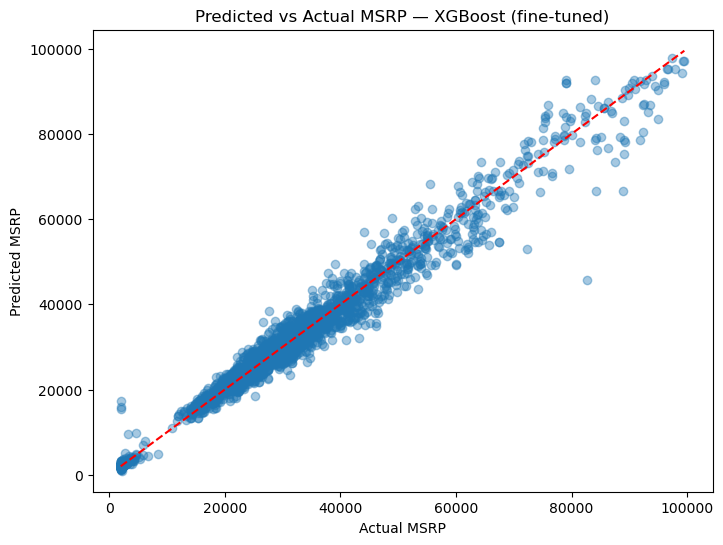

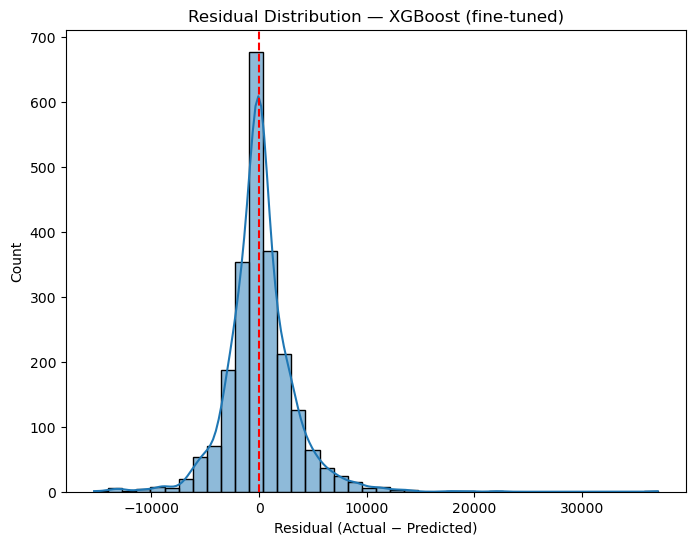

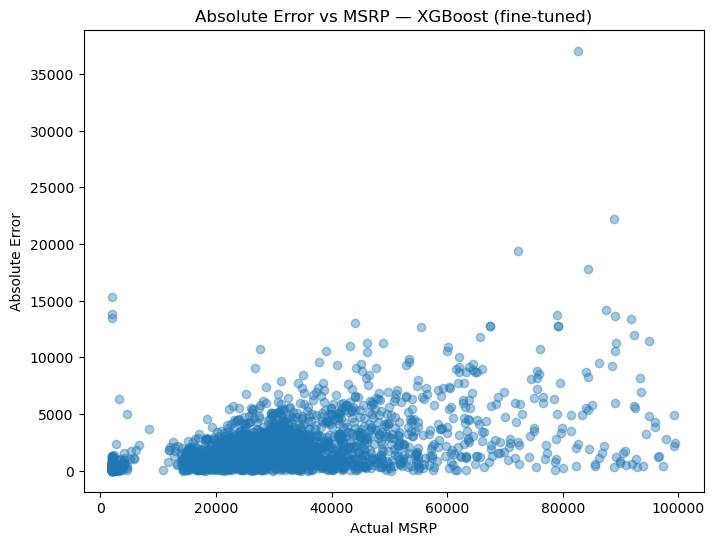

In [51]:
y_pred = best_model.predict(X_test)

df_pred = X_test.copy()
df_pred['MSRP_real'] = y_test.values
df_pred['MSRP_predicted'] = y_pred
df_pred['Absolute_Error'] = np.abs(y_test.values - y_pred)
df_pred['Residual'] = y_test.values - y_pred

plt.figure(figsize=(8,6))
plt.scatter(df_pred['MSRP_real'], df_pred['MSRP_predicted'], alpha=0.4)
plt.plot(
    [df_pred['MSRP_real'].min(), df_pred['MSRP_real'].max()],
    [df_pred['MSRP_real'].min(), df_pred['MSRP_real'].max()],
    'r--'
)
plt.xlabel("Actual MSRP")
plt.ylabel("Predicted MSRP")
plt.title("Predicted vs Actual MSRP — XGBoost (fine-tuned)")
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(df_pred['Residual'], bins=40, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual (Actual − Predicted)")
plt.title("Residual Distribution — XGBoost (fine-tuned)")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(df_pred['MSRP_real'], df_pred['Absolute_Error'], alpha=0.4)
plt.xlabel("Actual MSRP")
plt.ylabel("Absolute Error")
plt.title("Absolute Error vs MSRP — XGBoost (fine-tuned)")
plt.show()

Visual inspection of prediction plots further supports the choice of fine-tuned XGBoost when accuracy is the primary objective.

In [60]:
import joblib

joblib.dump(best_model, "price_model.pkl")
print("Modèle sauvegardé")


Modèle sauvegardé
